# 1. Cài đặt và Import thư viện

In [1]:
# Cài đặt các thư viện cần thiết
!pip install -q numpy==1.26.4 pandas==2.2.3 matplotlib==3.7.5 seaborn==0.12.2 scikit-learn==1.2.2 lightgbm==4.6.0 xgboost==2.0.3 catboost==1.2.7 optuna

In [2]:
import importlib.util

# Danh sách các thư viện cần kiểm tra phiên bản
libraries = [
    "numpy", "pandas", "matplotlib", "seaborn", "gc", "time", "warnings", 
    "datetime", "sklearn", "lightgbm", "xgboost", "catboost"
]

# Kiểm tra và hiển thị phiên bản của từng thư viện
for lib in libraries:
    spec = importlib.util.find_spec(lib)
    if spec is not None:
        module = importlib.import_module(lib)
        version = getattr(module, '__version__', 'Không có thông tin phiên bản')
        print(f"{lib}: {version}")
    else:
        print(f"{lib}: Không được cài đặt")

numpy: 1.26.4
pandas: 2.2.3
matplotlib: 3.7.5
seaborn: 0.12.2
gc: Không có thông tin phiên bản
time: Không có thông tin phiên bản
warnings: Không có thông tin phiên bản
datetime: Không có thông tin phiên bản
sklearn: 1.2.2
lightgbm: 4.6.0
xgboost: 2.0.3
catboost: 1.2.7


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
import optuna
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

In [4]:
# Cấu hình hiển thị
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

In [5]:
# Thiết lập style cho biểu đồ
plt.style.use('ggplot')
sns.set_style('whitegrid')

# 2. Tải dữ liệu

In [6]:
print("Đang tải dữ liệu...")
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv', dtype={'TransactionAmt': np.float32})
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv', dtype={'TransactionAmt': np.float32})
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')

Đang tải dữ liệu...


In [7]:
for df in [train_transaction, test_transaction, train_identity, test_identity]:
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype(np.float32)
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype(np.int32)

In [8]:
print(f'Train Transaction: {train_transaction.shape}')
print(f'Test Transaction: {test_transaction.shape}')
print(f'Train Identity: {train_identity.shape}')
print(f'Test Identity: {test_identity.shape}')

Train Transaction: (590540, 394)
Test Transaction: (506691, 393)
Train Identity: (144233, 41)
Test Identity: (141907, 41)


# 3. Tiền xử lý và Kỹ thuật Đặc trưng (Tối ưu hóa)
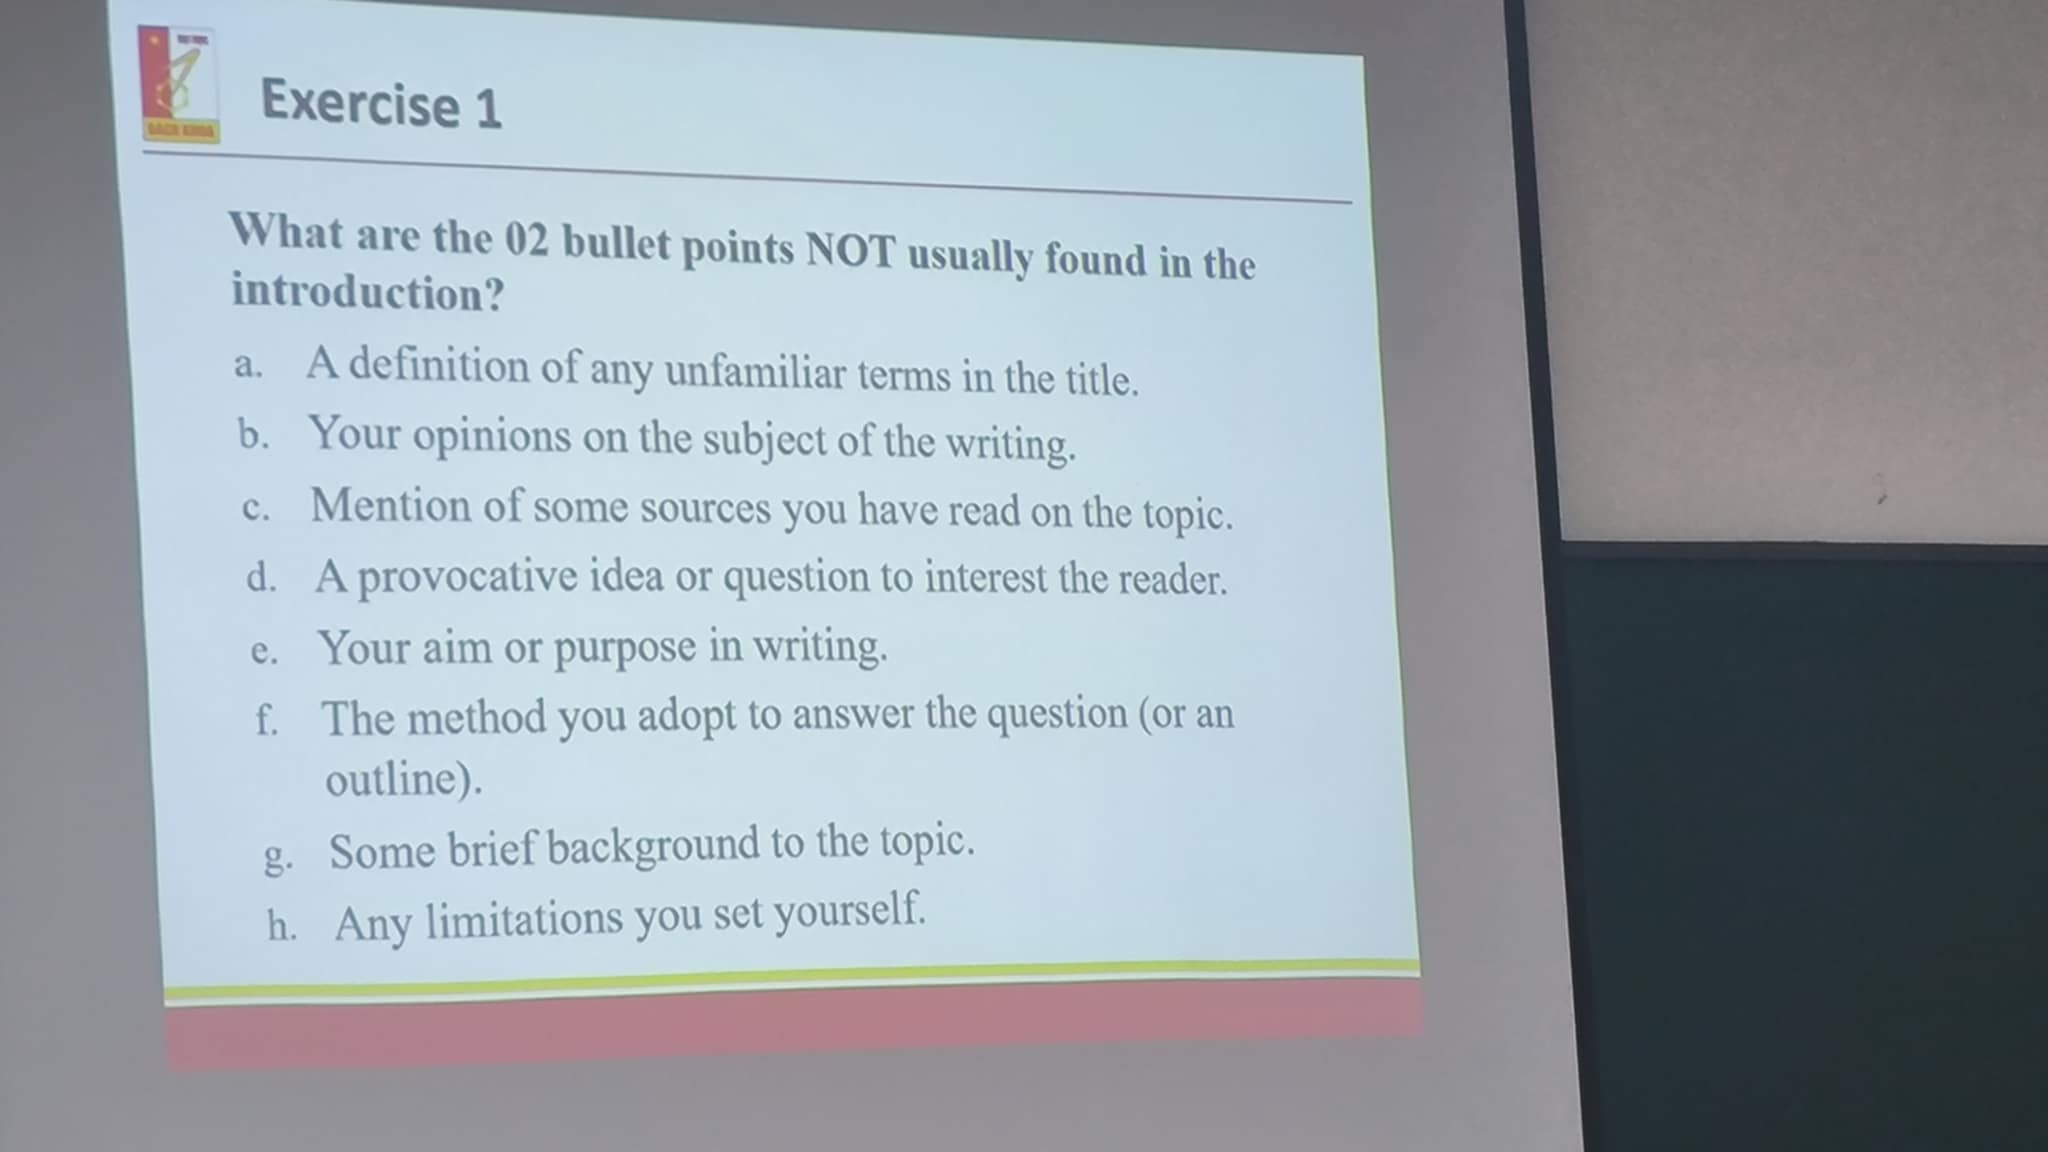
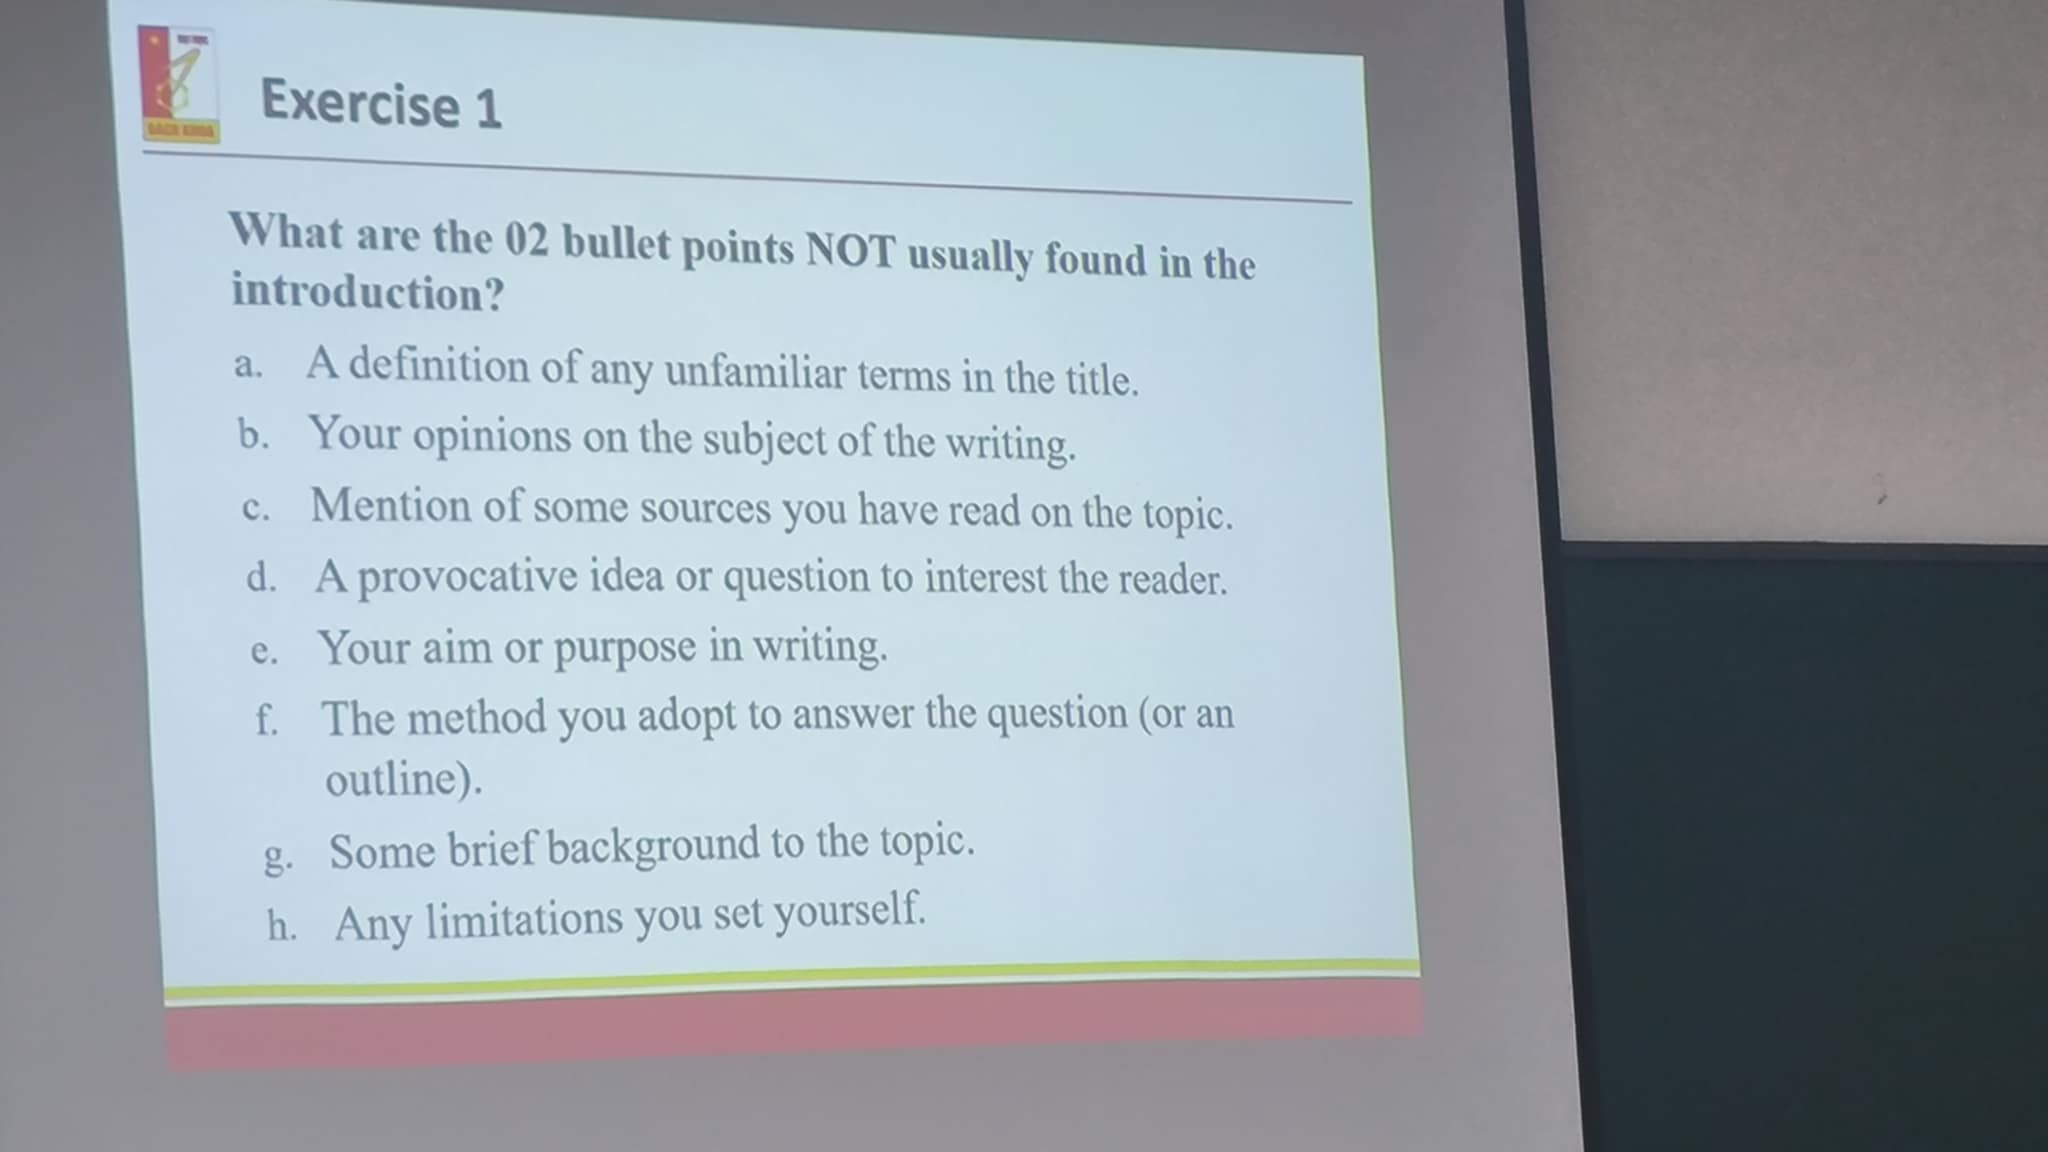

In [9]:
def preprocess_and_feature_engineering(train_transaction, test_transaction, train_identity, test_identity):
    print("Kết hợp dữ liệu...")
    train = train_transaction.merge(train_identity, on='TransactionID', how='left')
    test = test_transaction.merge(test_identity, on='TransactionID', how='left')
    
    train_id = train['TransactionID'].copy()
    test_id = test['TransactionID'].copy()
    target = train['isFraud'].copy()
    
    # 3.1 Đặc trưng Thời gian Nâng cao
    print("Tạo đặc trưng thời gian...")
    START_DATE = '2017-12-01'
    start_date = datetime.strptime(START_DATE, '%Y-%m-%d')
    
    for df in [train, test]:
        df['DT'] = df['TransactionDT'].apply(lambda x: (start_date + timedelta(seconds=x)))
        df['DT_M'] = df['DT'].dt.month
        df['DT_W'] = df['DT'].dt.isocalendar().week.astype(np.int32)
        df['DT_D'] = df['DT'].dt.dayofweek
        df['DT_hour'] = df['DT'].dt.hour
        df['DT_day'] = df['DT'].dt.day
        
        df['hour_sin'] = np.sin(2 * np.pi * df['DT_hour']/24.0).astype(np.float32)
        df['hour_cos'] = np.cos(2 * np.pi * df['DT_hour']/24.0).astype(np.float32)
        df['day_sin'] = np.sin(2 * np.pi * df['DT_D']/7.0).astype(np.float32)
        df['day_cos'] = np.cos(2 * np.pi * df['DT_D']/7.0).astype(np.float32)
        df['month_sin'] = np.sin(2 * np.pi * df['DT_M']/12.0).astype(np.float32)
        df['month_cos'] = np.cos(2 * np.pi * df['DT_M']/12.0).astype(np.float32)
        
        df['is_weekend'] = df['DT_D'].isin([5, 6]).astype(np.int8)
        df['is_night'] = ((df['DT_hour'] >= 20) | (df['DT_hour'] <= 6)).astype(np.int8)
    
    # 3.2 Đặc trưng TransactionAmt (giảm bớt số lượng đặc trưng)
    print("Tạo đặc trưng TransactionAmt...")
    for df in [train, test]:
        df['TransactionAmt_decimal'] = (df['TransactionAmt'] - np.floor(df['TransactionAmt'])).astype(np.float32)
        q1 = df['TransactionAmt'].quantile(0.25)
        q3 = df['TransactionAmt'].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        df['TransactionAmt_outlier'] = (df['TransactionAmt'] > upper_bound).astype(np.int8)
    
    # 3.3 Tạo UID (chỉ giữ 2 loại UID quan trọng)
    print("Tạo UID và đặc trưng tổng hợp...")
    for df in [train, test]:
        df['uid1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
        df['uid2'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['card2'].astype(str)
    
    # 3.4 Frequency Encoding (giảm số cột)
    print("Áp dụng Frequency Encoding...")
    freq_encode_cols = ['card1', 'addr1', 'uid1']
    
    for col in freq_encode_cols:
        train_freq = train[col].value_counts(dropna=False).to_dict()
        train[f'{col}_freq_enc'] = train[col].map(train_freq).astype(np.float32)
        test[f'{col}_freq_enc'] = test[col].map(train_freq).astype(np.float32)
        test[f'{col}_freq_enc'].fillna(1, inplace=True)
    
    # 3.5 Đặc trưng Tương tác (chỉ giữ tương tác quan trọng)
    print("Tạo đặc trưng tương tác...")
    for df in [train, test]:
        col = 'card1'
        col_mean = df.groupby([col])['TransactionAmt'].transform('mean')
        df[f'TransactionAmt_to_mean_{col}'] = (df['TransactionAmt'] / col_mean).astype(np.float32)
    
    # 3.6 Đặc trưng tổng hợp theo UID (xử lý theo batch)
    print("Tạo đặc trưng tổng hợp theo UID...")
    batch_size = 100000
    for uid in ['uid1']:
        for df in [train, test]:
            df[f'{uid}_count'] = np.zeros(len(df), dtype=np.float32)
            df[f'{uid}_amt_mean'] = np.zeros(len(df), dtype=np.float32)
            
            num_batches = len(df) // batch_size + (1 if len(df) % batch_size else 0)
            for i in range(num_batches):
                start = i * batch_size
                end = min((i + 1) * batch_size, len(df))
                batch = df.iloc[start:end].copy()
                batch[f'{uid}_count'] = batch.groupby([uid])['TransactionID'].transform('count').astype(np.float32)
                batch[f'{uid}_amt_mean'] = batch.groupby([uid])['TransactionAmt'].transform('mean').astype(np.float32)
                df.iloc[start:end, df.columns.get_loc(f'{uid}_count')] = batch[f'{uid}_count']
                df.iloc[start:end, df.columns.get_loc(f'{uid}_amt_mean')] = batch[f'{uid}_amt_mean']
                del batch
                gc.collect()
    
    # 3.7 Xử lý giá trị thiếu
    print("Xử lý giá trị thiếu...")
    for df in [train, test]:
        for col in df.columns:
            if col in ['TransactionID', 'DT']:
                continue
            if df[col].dtype != 'object':
                df[col] = df[col].fillna(-999).astype(np.float32)
            else:
                df[col] = df[col].fillna('missing')
    
    # 3.8 Label Encoding (sửa lỗi KeyError bằng cách chỉ mã hóa các cột tồn tại trong cả train và test)
    print("Mã hóa đặc trưng phân loại...")
    # Lấy danh sách các cột phân loại có trong cả train và test
    cat_cols = [col for col in train.columns if train[col].dtype == 'object' and col in test.columns]
    for col in cat_cols:
        le = LabelEncoder()
        # Tạo DataFrame tạm thời để kết hợp dữ liệu từ train và test
        combined = pd.concat([train[[col]].astype(str), test[[col]].astype(str)], axis=0)
        le.fit(combined[col])
        train[col] = le.transform(train[col].astype(str)).astype(np.int32)
        test[col] = le.transform(test[col].astype(str)).astype(np.int32)
        del combined
        gc.collect()
    
    # 3.9 Loại bỏ các cột không cần thiết
    cols_to_drop = ['TransactionID', 'DT']
    train = train.drop(cols_to_drop + ['isFraud'], axis=1)
    test = test.drop(cols_to_drop, axis=1)
    
    # Đảm bảo các cột trong train và test giống nhau
    common_cols = train.columns.intersection(test.columns)
    train = train[common_cols]
    test = test[common_cols]
    
    del train_transaction, test_transaction, train_identity, test_identity
    gc.collect()
    
    return train, test, target, train_id, test_id

In [10]:
# Tiền xử lý và tạo đặc trưng
print("Bắt đầu tiền xử lý và tạo đặc trưng...")
X, X_test, y, train_id, test_id = preprocess_and_feature_engineering(
    train_transaction, test_transaction, train_identity, test_identity)

Bắt đầu tiền xử lý và tạo đặc trưng...
Kết hợp dữ liệu...
Tạo đặc trưng thời gian...
Tạo đặc trưng TransactionAmt...
Tạo UID và đặc trưng tổng hợp...
Áp dụng Frequency Encoding...
Tạo đặc trưng tương tác...
Tạo đặc trưng tổng hợp theo UID...
Xử lý giá trị thiếu...
Mã hóa đặc trưng phân loại...


In [11]:
print(f"X shape: {X.shape}")
print(f"X_test shape: {X_test.shape}")

X shape: (590540, 417)
X_test shape: (506691, 417)


# 4. Time-Based Cross-Validation

In [12]:
print("Thiết lập Time-Based Cross-Validation...")
tscv = TimeSeriesSplit(n_splits=5)
folds = list(tscv.split(X))

Thiết lập Time-Based Cross-Validation...


# 5. Huấn luyện LightGBM với Time-Based CV

In [13]:
print("Huấn luyện LightGBM...")
oof_preds_lgb = np.zeros(len(X), dtype=np.float32)
test_preds_lgb = np.zeros(len(X_test), dtype=np.float32)
feature_importance_df_lgb = pd.DataFrame()

Huấn luyện LightGBM...


In [14]:
lgb_params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "auc",
    "n_jobs": -1,
    "learning_rate": 0.01,
    "num_leaves": 256,  # Giảm để tiết kiệm RAM
    "max_depth": 8,
    "tree_learner": "serial",
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "min_child_weight": 1,
    "min_child_samples": 20,
    "scale_pos_weight": 1,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "verbose": -1,
    "seed": 42,
    "device": "gpu"  # Tận dụng GPU
}

In [15]:
NFOLDS = 5
for fold_, (trn_idx, val_idx) in enumerate(folds):
    print(f"LightGBM - Fold {fold_+1}/{NFOLDS}")
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])

    clf = lgb.train(
        lgb_params,
        trn_data,
        valid_sets=[trn_data, val_data],
        valid_names=["train", "val"],
        num_boost_round=10000,
        callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=100)]
    )

    oof_preds_lgb[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)
    test_preds_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / NFOLDS

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["Importance"] = clf.feature_importance(importance_type="gain")
    fold_importance_df["Fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df], axis=0)

    np.save(f'/kaggle/working/oof_preds_lgb_fold_{fold_+1}.npy', oof_preds_lgb[val_idx])
    del clf, trn_data, val_data
    gc.collect()

LightGBM - Fold 1/5


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.921227	val's auc: 0.86885
[200]	train's auc: 0.954014	val's auc: 0.882279
[300]	train's auc: 0.970894	val's auc: 0.890674
[400]	train's auc: 0.977435	val's auc: 0.895414
[500]	train's auc: 0.980916	val's auc: 0.897582
[600]	train's auc: 0.983877	val's auc: 0.898543
[700]	train's auc: 0.986661	val's auc: 0.899172
[800]	train's auc: 0.989057	val's auc: 0.899766
[900]	train's auc: 0.990773	val's auc: 0.899791
Early stopping, best iteration is:
[848]	train's auc: 0.989969	val's auc: 0.899962
LightGBM - Fold 2/5
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.918862	val's auc: 0.891719
[200]	train's auc: 0.943479	val's auc: 0.902112
[300]	train's auc: 0.957293	val's auc: 0.908598
[400]	train's auc: 0.964736	val's auc: 0.911816
[500]	train's auc: 0.970236	val's auc: 0.914549
[600]	train's auc: 0.973959	val's auc: 0.915548
[700]	train's auc: 0.976404	val's auc: 0.915785
[800]	

In [16]:
oof_auc_lgb = roc_auc_score(y, oof_preds_lgb)
print(f"LightGBM OOF AUC: {oof_auc_lgb:.6f}")

LightGBM OOF AUC: 0.825270


# 6. Huấn luyện XGBoost với Time-Based CV

In [17]:
print("Huấn luyện XGBoost...")
oof_preds_xgb = np.zeros(len(X), dtype=np.float32)
test_preds_xgb = np.zeros(len(X_test), dtype=np.float32)

Huấn luyện XGBoost...


In [18]:
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.02,
    "max_depth": 8,
    "min_child_weight": 1,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "alpha": 0.1,
    "lambda": 0.1,
    "tree_method": "gpu_hist",  # Tận dụng GPU
    "nthread": -1,
    "scale_pos_weight": 1,
    "seed": 42
}

In [19]:
for fold_, (trn_idx, val_idx) in enumerate(folds):
    print(f"XGBoost - Fold {fold_+1}/{NFOLDS}")
    trn_data = xgb.DMatrix(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = xgb.DMatrix(X.iloc[val_idx], label=y.iloc[val_idx])
    watchlist = [(trn_data, "train"), (val_data, "val")]

    clf = xgb.train(
        xgb_params,
        trn_data,
        num_boost_round=10000,
        evals=watchlist,
        early_stopping_rounds=100,
        verbose_eval=100
    )

    oof_preds_xgb[val_idx] = clf.predict(val_data, iteration_range=(0, clf.best_iteration + 1))
    test_preds_xgb += clf.predict(xgb.DMatrix(X_test), iteration_range=(0, clf.best_iteration + 1)) / NFOLDS

    np.save(f'/kaggle/working/oof_preds_xgb_fold_{fold_+1}.npy', oof_preds_xgb[val_idx])
    del clf, trn_data, val_data
    gc.collect()

XGBoost - Fold 1/5
[0]	train-auc:0.82025	val-auc:0.78511
[100]	train-auc:0.92423	val-auc:0.87036
[200]	train-auc:0.97147	val-auc:0.89269
[300]	train-auc:0.98764	val-auc:0.90003
[400]	train-auc:0.99292	val-auc:0.90195
[500]	train-auc:0.99606	val-auc:0.90285
[600]	train-auc:0.99791	val-auc:0.90191
[633]	train-auc:0.99828	val-auc:0.90187
XGBoost - Fold 2/5
[0]	train-auc:0.80865	val-auc:0.77842
[100]	train-auc:0.91800	val-auc:0.89367
[200]	train-auc:0.96225	val-auc:0.91078
[300]	train-auc:0.97713	val-auc:0.91887
[400]	train-auc:0.98361	val-auc:0.92058
[500]	train-auc:0.98815	val-auc:0.92221
[600]	train-auc:0.99123	val-auc:0.92123
[618]	train-auc:0.99174	val-auc:0.92122
XGBoost - Fold 3/5
[0]	train-auc:0.81044	val-auc:0.76693
[100]	train-auc:0.91810	val-auc:0.87601
[200]	train-auc:0.95299	val-auc:0.89698
[300]	train-auc:0.96906	val-auc:0.90586
[400]	train-auc:0.97666	val-auc:0.91010
[500]	train-auc:0.98184	val-auc:0.91230
[600]	train-auc:0.98606	val-auc:0.91362
[700]	train-auc:0.98918	val-a

In [20]:
oof_auc_xgb = roc_auc_score(y, oof_preds_xgb)
print(f"XGBoost OOF AUC: {oof_auc_xgb:.6f}")

XGBoost OOF AUC: 0.827969


# 7. Huấn luyện CatBoost với Time-Based CV

In [21]:
print("Huấn luyện CatBoost...")
oof_preds_cat = np.zeros(len(X), dtype=np.float32)
test_preds_cat = np.zeros(len(X_test), dtype=np.float32)
feature_importance_df_cat = pd.DataFrame()

Huấn luyện CatBoost...


In [22]:
cat_params = {
    "iterations": 5000,
    "learning_rate": 0.02,
    "depth": 8,
    "l2_leaf_reg": 10,
    "bootstrap_type": "Bernoulli",
    "subsample": 0.7,
    "scale_pos_weight": 1,
    "eval_metric": "AUC",
    "metric_period": 100,
    "od_type": "Iter",
    "od_wait": 200,
    "random_seed": 42,
    "allow_writing_files": False,
    "task_type": "GPU",
    "verbose": 100,
    "used_ram_limit": "20gb"
}

In [23]:
for fold_, (trn_idx, val_idx) in enumerate(folds):
    print(f"CatBoost - Fold {fold_+1}/{NFOLDS}")
    X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    clf = CatBoostClassifier(**cat_params)
    clf.fit(
        X_trn, y_trn,
        eval_set=(X_val, y_val),
        use_best_model=True,
        
        verbose=False
    )

    oof_preds_cat[val_idx] = clf.predict_proba(X_val)[:, 1]
    test_preds_cat += clf.predict_proba(X_test)[:, 1] / NFOLDS

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["Importance"] = clf.get_feature_importance()
    fold_importance_df["Fold"] = fold_ + 1
    feature_importance_df_cat = pd.concat([feature_importance_df_cat, fold_importance_df], axis=0)

    np.save(f'/kaggle/working/oof_preds_cat_fold_{fold_+1}.npy', oof_preds_cat[val_idx])
    del clf, X_trn, y_trn, X_val, y_val
    gc.collect()

CatBoost - Fold 1/5
CatBoost - Fold 2/5
CatBoost - Fold 3/5
CatBoost - Fold 4/5
CatBoost - Fold 5/5


In [24]:
# Đánh giá OOF AUC
oof_auc_cat = roc_auc_score(y, oof_preds_cat)
print(f"CatBoost OOF AUC: {oof_auc_cat:.6f}")

CatBoost OOF AUC: 0.820907


# 8. Stacking với LogisticRegression

In [25]:
print("Áp dụng Stacking...")
meta_features = np.column_stack((oof_preds_lgb, oof_preds_xgb, oof_preds_cat)).astype(np.float32)
meta_model = LogisticRegression(solver='liblinear', random_state=42)
meta_model.fit(meta_features, y)

Áp dụng Stacking...


LogisticRegression(random_state=42, solver='liblinear')

In [26]:
test_meta_features = np.column_stack((test_preds_lgb, test_preds_xgb, test_preds_cat)).astype(np.float32)
test_preds_stack = meta_model.predict_proba(test_meta_features)[:, 1]

In [27]:
oof_preds_stack = meta_model.predict_proba(meta_features)[:, 1]
oof_auc_stack = roc_auc_score(y, oof_preds_stack)
print(f"Stacking OOF AUC: {oof_auc_stack:.6f}")

Stacking OOF AUC: 0.828250


# 9. Kết hợp mô hình với trọng số tùy chỉnh

In [28]:
print("Kết hợp mô hình với trọng số tùy chỉnh...")
weights_options = [
    [0.1, 0.6, 0.3],
    [0.2, 0.6, 0.2],
    [0.3, 0.5, 0.2],
    [0.0, 0.7, 0.3],
    [0.2, 0.5, 0.3]
]

Kết hợp mô hình với trọng số tùy chỉnh...


In [29]:
best_auc = 0
best_weights = None

In [30]:
for weights in weights_options:
    oof_combined = weights[0] * oof_preds_lgb + weights[1] * oof_preds_xgb + weights[2] * oof_preds_cat
    oof_auc_combined = roc_auc_score(y, oof_combined)
    print(f"OOF AUC với trọng số {weights}: {oof_auc_combined:.6f}")
    
    if oof_auc_combined > best_auc:
        best_auc = oof_auc_combined
        best_weights = weights

OOF AUC với trọng số [0.1, 0.6, 0.3]: 0.828121
OOF AUC với trọng số [0.2, 0.6, 0.2]: 0.828367
OOF AUC với trọng số [0.3, 0.5, 0.2]: 0.828302
OOF AUC với trọng số [0.0, 0.7, 0.3]: 0.827974
OOF AUC với trọng số [0.2, 0.5, 0.3]: 0.828136


In [31]:
print(f"Trọng số tốt nhất: {best_weights} với OOF AUC: {best_auc:.6f}")

Trọng số tốt nhất: [0.2, 0.6, 0.2] với OOF AUC: 0.828367


In [32]:
# So sánh với stacking
if oof_auc_stack > best_auc:
    print(f"Stacking tốt hơn với OOF AUC: {oof_auc_stack:.6f}")
    test_pred_final = test_preds_stack
else:
    print(f"Kết hợp trọng số tốt hơn với OOF AUC: {best_auc:.6f}")
    test_pred_final = best_weights[0] * test_preds_lgb + best_weights[1] * test_preds_xgb + best_weights[2] * test_preds_cat

Kết hợp trọng số tốt hơn với OOF AUC: 0.828367


# 10. Tạo file nộp bài

In [33]:
print("Tạo file nộp bài...")
submission = pd.DataFrame({
    "TransactionID": test_id,
    "isFraud": test_pred_final
})

Tạo file nộp bài...


In [34]:
# Lưu file nộp bài
submission.to_csv("submission_advanced.csv", index=False)

In [35]:
# Hiển thị thông tin về file nộp bài
print("\nThông tin về file nộp bài:")
print(submission.describe())
print(f"Số lượng giao dịch: {len(submission)}")


Thông tin về file nộp bài:
       TransactionID        isFraud
count   5.066910e+05  506691.000000
mean    3.916894e+06       0.029823
std     1.462692e+05       0.109921
min     3.663549e+06       0.000309
25%     3.790222e+06       0.003382
50%     3.916894e+06       0.006691
75%     4.043566e+06       0.014513
max     4.170239e+06       0.997084
Số lượng giao dịch: 506691


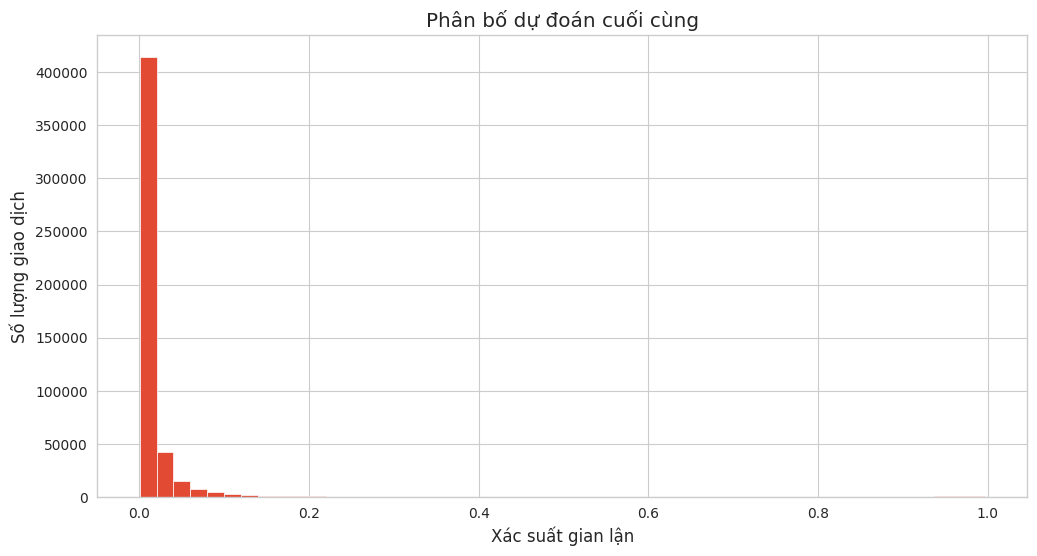

In [36]:
# Vẽ biểu đồ phân bố dự đoán
plt.figure(figsize=(12, 6))
plt.hist(submission["isFraud"], bins=50)
plt.title("Phân bố dự đoán cuối cùng")
plt.xlabel("Xác suất gian lận")
plt.ylabel("Số lượng giao dịch")
plt.show()

# 11. Hiển thị đặc trưng quan trọng

Hiển thị đặc trưng quan trọng...


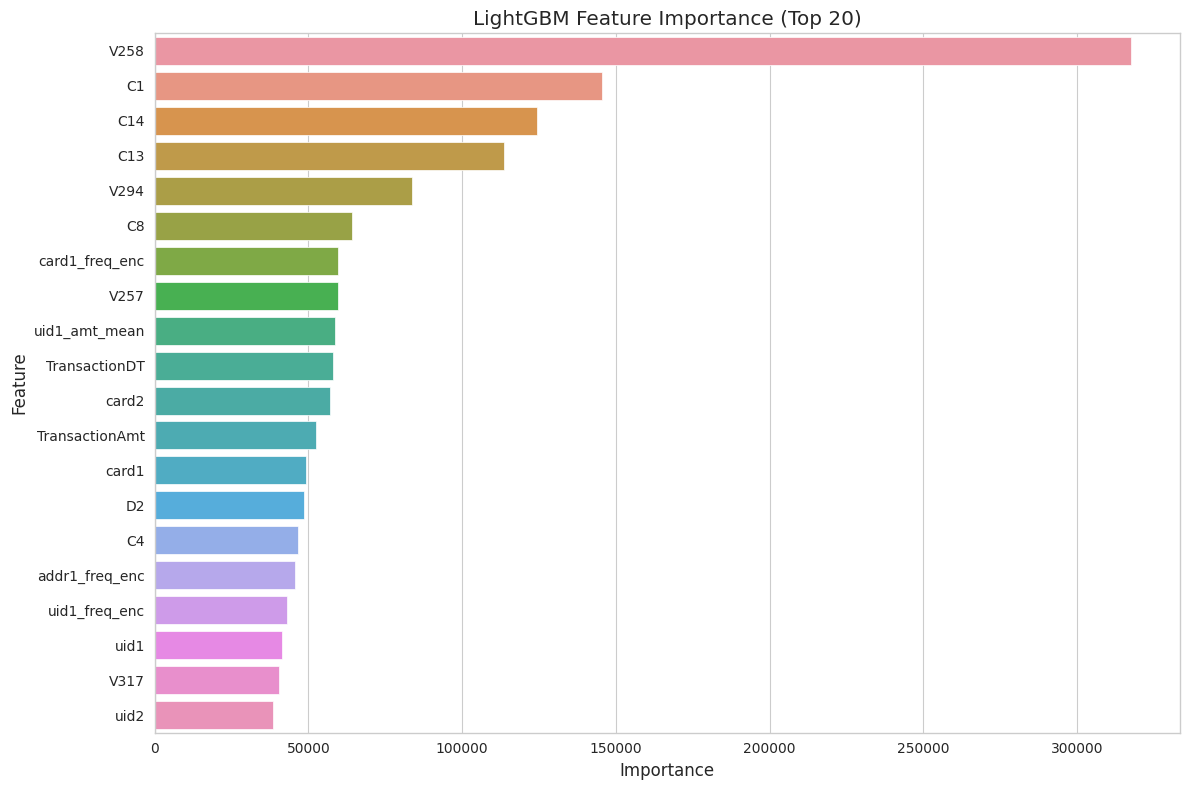

In [37]:
print("Hiển thị đặc trưng quan trọng...")
# LightGBM
mean_importance_lgb = feature_importance_df_lgb[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=mean_importance_lgb.Importance.head(20), y=mean_importance_lgb.head(20).index)
plt.title("LightGBM Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

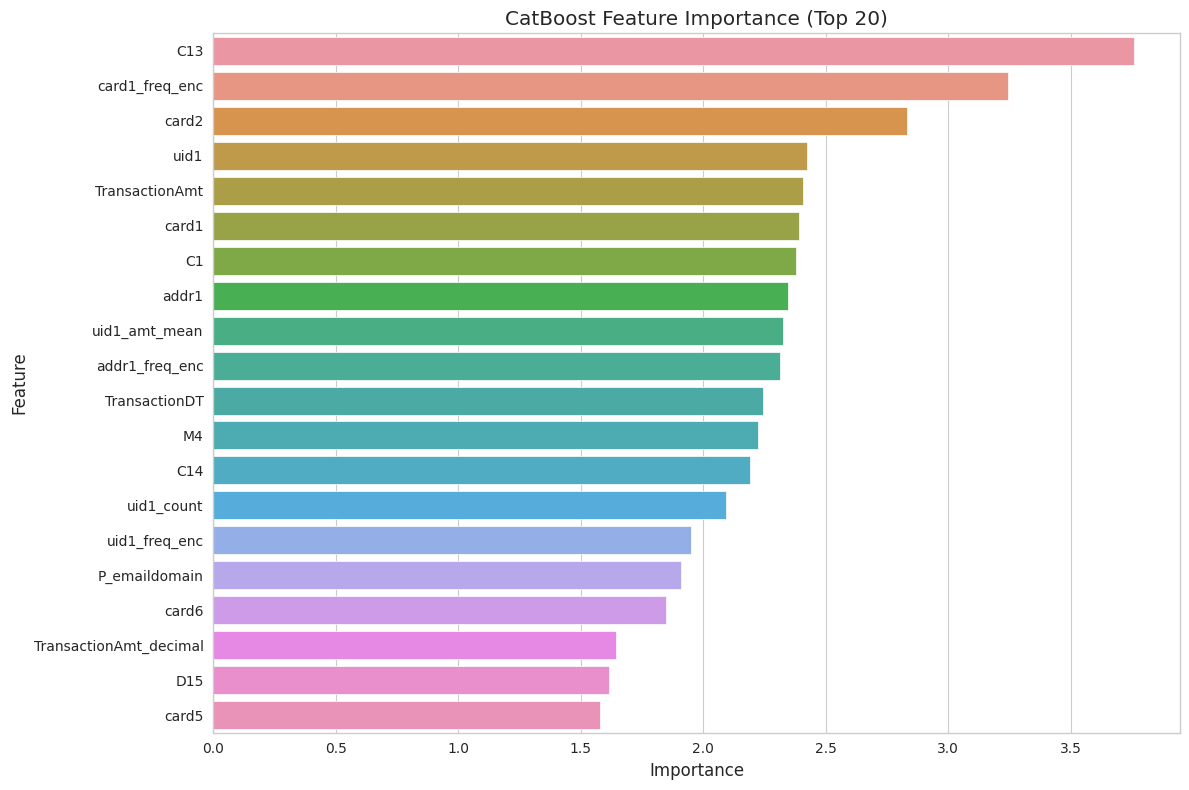

In [38]:
# CatBoost
mean_importance_cat = feature_importance_df_cat[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=mean_importance_cat.Importance.head(20), y=mean_importance_cat.head(20).index)
plt.title("CatBoost Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

In [39]:
del X, X_test, y, train_id, test_id, oof_preds_lgb, test_preds_lgb, oof_preds_xgb, test_preds_xgb, oof_preds_cat, test_preds_cat, meta_features, test_meta_features, test_pred_final, submission
gc.collect()

17825

In [40]:
print("Hoàn thành!")

Hoàn thành!
